In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler

import pandas as pd
from glob import glob
import re

import seaborn as sns
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

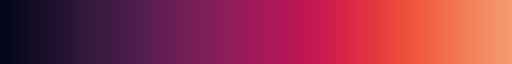

In [2]:
# Define a function to truncate a colormap.
# 'cmap' is the original colormap.
# 'minval' and 'maxval' are the range values to truncate the colormap.
# 'n' is the number of discrete colors to use in the new colormap.
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # Create a new colormap by truncating the original colormap.
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Get the 'rocket' colormap from matplotlib's colormap library.
cmap = plt.get_cmap('rocket')

# Truncate the 'rocket' colormap to only include colors in the range [0, 0.8].
new_cmap = truncate_colormap(cmap, 0, 0.8)

# Set the color for bad (masked) values to black in the new colormap.
new_cmap.set_bad('black')

# Output the truncated colormap.
new_cmap

In [ ]:
spark = (
    SparkSession
    .builder
    .config("spark.driver.memory", "4g")
    .getOrCreate())
sc = spark.sparkContext

In [ ]:
# Define the function 'ss' to perform data processing and scaling for a given session, tuning, and polarization.
def ss(session, tun, pol):
    # Read Parquet files for the specified session, tuning, and polarization into a Spark DataFrame.
    temp_df = spark.read.parquet(f'project_data/LH014/parquets/{session}_{tun}_{pol}*.parquet')
    
    # Process the DataFrame:
    # - Cast the 'time' column to integer and store it as 'seconds'.
    # - Round the 'frequency' column to 2 decimal places and store it as 'frequency2'.
    # - Group by 'seconds' and 'frequency2', and aggregate the 'value' column by summing it.
    temp_df = (temp_df
               .withColumn('seconds', col('time').cast('int'))
               .withColumn('frequency2', round('frequency', 2))
               .groupby('seconds', 'frequency2').agg(sum('value').alias('value'))
              )
    
    # Assemble the 'value' column into a feature vector named 'value_vec'.
    assembler = VectorAssembler(inputCols=['value'], outputCol='value_vec')
    df_assembled = assembler.transform(temp_df)
    
    # Initialize the StandardScaler to scale the 'value_vec' column.
    scaler = StandardScaler(inputCol='value_vec', outputCol='scaled_value', withStd=True, withMean=True)
    
    # Fit the scaler to the DataFrame and transform the DataFrame.
    scaler_model = scaler.fit(df_assembled)
    df_scaled = scaler_model.transform(df_assembled)
    
    # Define a UDF to convert the scaled value vector to a float.
    to_float = udf(lambda vector: float(vector[0]))
    
    # Apply the UDF to the 'scaled_value' column and drop the 'value_vec' column.
    df_scaled = df_scaled.withColumn('scaled_value', to_float('scaled_value')).drop('value_vec')
    
    # Write the scaled DataFrame to Parquet files in overwrite mode.
    df_scaled.write.mode('overwrite').parquet('project_data/LH014/figs/temp/')
    
    # Read the temporary Parquet files into a list of Pandas DataFrames.
    temp_files = glob.glob('project_data/LH014/figs/temp/*.parquet')
    temp_df = [pd.read_parquet(file) for file in temp_files]
    
    # Concatenate the list of DataFrames into a single DataFrame.
    temp_df = pd.concat(temp_df)
    
    # Write the final DataFrame to a Parquet file.
    temp_df.to_parquet(f'project_data/LH014/figs/{session}_{tun}_{pol}_SS.parquet')


In [ ]:
%%time
s = '141'
ss(s,'Tuning2','V')
ss(s,'Tuning2','I')
ss(s,'Tuning1','I') 
ss(s,'Tuning1','V')

In [ ]:
glob('project_data/LH014/figs/*_SS.parquet')

In [ ]:
# Define the function 'ss_fig' to create and save a heatmap for a given session, tuning, and polarization.
def ss_fig(session, tun, pol):
    # Read the Parquet file for the specified session, tuning, and polarization into a Pandas DataFrame.
    temp_df = pd.read_parquet(f'project_data/LH014/figs/{session}_{tun}_{pol}_SS.parquet')
    
    # Ensure the 'scaled_value' column is of type float.
    temp_df.scaled_value = temp_df.scaled_value.astype(float)
    
    # Get the start time in a readable format.
    t1 = pd.to_datetime(temp_df.seconds.iloc[0], unit='s').strftime("%Y-%m-%dT%H:%M:%S")
    
    # Convert the 'seconds' column to datetime format and store it in a new column 'time'.
    temp_df['time'] = pd.to_datetime(temp_df.seconds, unit='s')
    
    # Extract the time part (HH:MM:SS) from the 'time' column and store it in a new column 'time2'.
    temp_df['time2'] = temp_df.time.dt.strftime("%H:%M:%S")
    
    # Create a pivot table with 'frequency2' as rows, 'time2' as columns, and 'scaled_value' as values.
    heatmap_data = temp_df.pivot('frequency2', 'time2', 'scaled_value')
    
    # Sort the pivot table by 'frequency2' in descending order.
    heatmap_data.sort_values('frequency2', ascending=False, inplace=True)
    
    # Create a figure and axis for the heatmap.
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the heatmap using seaborn.
    sns.heatmap(heatmap_data, cmap=new_cmap, ax=ax, cbar_kws={'label': 'StandardScaler'}, vmin=-1, vmax=1)
    
    # Set the title for the heatmap.
    title = f'Session {session}, {tun}, Stokes: {pol}, Date: {t1}'
    ax.set_title(title)
    
    # Adjust the number of bins for the y-axis and x-axis.
    ax.locator_params(axis='y', nbins=10)
    ax.locator_params(axis='x', nbins=10)
    
    # Rotate the x-axis labels for better readability.
    plt.xticks(rotation=45)
    
    # Set the labels for the y-axis and x-axis.
    ax.set_ylabel('Frequency MHz')
    ax.set_xlabel('')
    
    # Save the heatmap as a PNG file.
    plt.savefig(f'project_data/LH014/figs/{session}_{tun}_{pol}_SS.png')


In [ ]:
%%time
# ss_fig('project_data/LH014/figs/101_Tuning2_V_SS.parquet')
ss_fig('261','Tuning2','V')

In [ ]:
# Define the function 'ss_fig_bands' to create and save heatmaps for a given session, tuning, and polarization.
def ss_fig_bands(session, tun, pol):
    # Read the Parquet file for the specified session, tuning, and polarization into a Pandas DataFrame.
    temp_df = pd.read_parquet(f'project_data/LH014/figs/{session}/{session}_{tun}_{pol}_SS.parquet')
    
    # Ensure the 'scaled_value' column is of type float.
    temp_df.scaled_value = temp_df.scaled_value.astype(float)
    
    # Get the start time in a readable format.
    t1 = pd.to_datetime(temp_df.seconds.iloc[0], unit='s').strftime("%Y-%m-%dT%H:%M:%S")
    
    # Convert the 'seconds' column to datetime format and store it in a new column 'time'.
    temp_df['time'] = pd.to_datetime(temp_df.seconds, unit='s')
    
    # Extract the time part (HH:MM:SS) from the 'time' column and store it in a new column 'time2'.
    temp_df['time2'] = temp_df.time.dt.strftime("%H:%M:%S")
    
    # Create a pivot table with 'frequency2' as rows, 'time2' as columns, and 'scaled_value' as values.
    heatmap_data = temp_df.pivot('frequency2', 'time2', 'scaled_value')
    
    # Sort the pivot table by 'frequency2' in descending order.
    heatmap_data.sort_values('frequency2', ascending=False, inplace=True)
    
    # Generate heatmaps for different value ranges.
    for i in [-0.9, -0.7, -0.5, -0.3]:
        # Create a figure and axis for the heatmap.
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create the heatmap using seaborn.
        sns.heatmap(heatmap_data, cmap=new_cmap, ax=ax, cbar_kws={'label': 'StandardScaler'}, vmin=i, vmax=1)
        
        # Set the title for the heatmap.
        title = f'Session {session}, {tun}, Stokes: {pol}, Date: {t1}'
        ax.set_title(title)
        
        # Adjust the number of bins for the y-axis and x-axis.
        ax.locator_params(axis='y', nbins=10)
        ax.locator_params(axis='x', nbins=10)
        
        # Rotate the x-axis labels for better readability.
        plt.xticks(rotation=45)
        
        # Set the labels for the y-axis and x-axis.
        ax.set_ylabel('Frequency MHz')
        ax.set_xlabel('')
        
        # Save the heatmap as a PNG file.
        plt.savefig(f'project_data/LH014/figs/{session}_{tun}_{pol}_SS_{str(i)}.png')
        
        # Close the figure
        plt.close()

In [ ]:
%%time
s = '271'
ss_fig_bands(s,'Tuning1','I')
ss_fig_bands(s,'Tuning1','V')
ss_fig_bands(s,'Tuning2','I')
ss_fig_bands(s,'Tuning2','V')

In [ ]:
%%time
to_do = ['141', '151']

##'191'] ##'181' heat_map errors with these two
for s in to_do:
    print(s)
    ss_fig_bands(s,'Tuning1','I')
    ss_fig_bands(s,'Tuning1','V')
    ss_fig_bands(s,'Tuning2','I')
    ss_fig_bands(s,'Tuning2','V')


In [ ]:
spark.stop()